In [12]:
import torch 
import gpytorch
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath('..'))
from plotting import plot_train_test_split, plot_grid
from data.utils import *
from data.generator import PVDataGenerator
from data.loader import PVDataLoader

In [5]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 100
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 55
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [7]:
df_location = load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



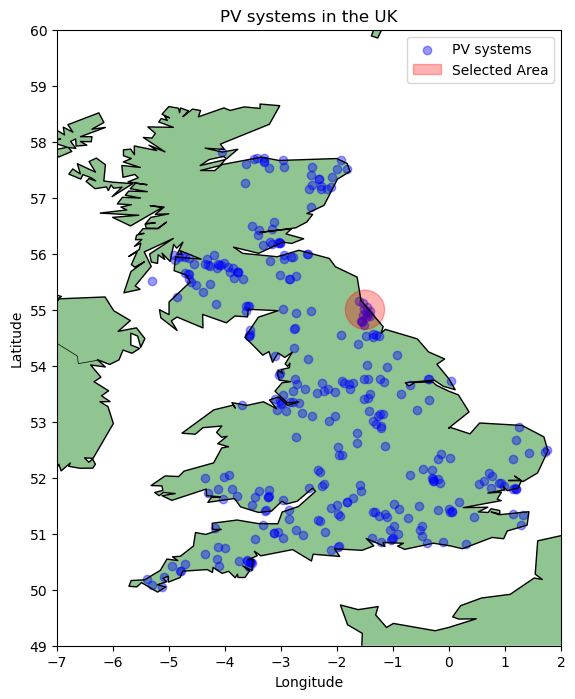

In [8]:
plot_grid(df_location, CIRCLE_COORDS, distance_method='circle', radius=RADIUS)

In [9]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=False)

X, y = generator.get_time_series()

N_TASKS = y.size(-1)
NUM_LATENT = 5

==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [10]:
# creates list of x and y values for each fold split by a given number of days
x_list, y_list = cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_DATA_POINTS)

In [11]:
# each coupled list is a series of n_days of data where the last n_hours_pred data points are the target
# the last n_hours_pred data points are randomly selected to be in any interval of the day 
# between day_min and day_max - n_hours_pred to avoid inductive bias of the model by the time of the day
x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, DAILY_DATA_POINTS, DAY_MIN, DAY_MAX)

In [13]:
# creates loaders for training and testing data to iterate over
train_loader = PVDataLoader(x_train, y_train)
test_loader = PVDataLoader(x_test, y_test)

In [14]:
# visualize the systems split into the training and test set for one sample
x_sample, y_sample = next(iter(train_loader))


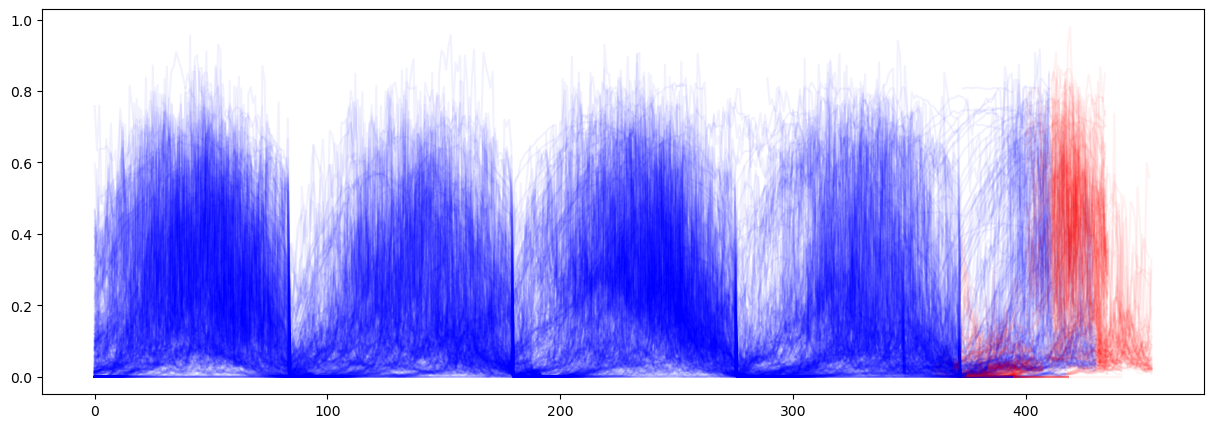

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader, test_loader):
    plt.plot(x_tr[:,0].numpy(), y_tr.numpy(), color='b', alpha=0.05)
    plt.plot(x_te[:,0].numpy(), y_te.numpy(), color='r', alpha=0.05)